In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [3]:
li = [[],[],[]]
for i, subfolder in zip(range(3), ['RAD', 'gt', 'stereo_image']):
    for filename in os.listdir('/kaggle/input/carrada/test/' + str(subfolder)):
            li[i].append(os.path.join('/kaggle/input/carrada/test/' + str(subfolder), filename))
            li[i].sort()
df = pd.DataFrame({'rad':li[0], 'gt':li[1], 'images':li[2]})


imageid_bbox_label = [[], [], []]
for file in li[1]:
    for j in ['classes', 'boxes']:
        file_content = pd.read_pickle(file)
        for i in range(len(file_content[j])):
            if j == 'classes':
                imageid_bbox_label[0].append( file.split('/')[-1][:-7] )#'/kaggle/input/carrada/test/RAD/' + + '.npy'
                imageid_bbox_label[2].append(file_content[j][i])  
            else:
                # x, y, z are center point
                w = file_content[j][i][3] 
                d = file_content[j][i][5] 
                x1 = file_content[j][i][0] - 0.5 * w
                z1 = file_content[j][i][2] - 0.5 * d
                x2 = x1 + 0.5 * w
                z2 = z1 + 0.5 * d
                if z1 < 0:
                    z1 = 0
                xzxz = [x1, z1, x2, z2]  #get only xyxy instead of xzxz
                imageid_bbox_label[1].append(xzxz)
df = pd.DataFrame(imageid_bbox_label).T
df = df.rename(columns={0:'filename',1:'bbox',2:'class_label'})
data = df.copy()
classes = {'truck':4, 'car':2, 'person':3, 'bicycle':0, 'bus':1}
df.class_label = df.class_label.replace(classes)

/tmp/ipykernel_34/817964394.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.class_label = df.class_label.replace(classes)


In [4]:
class preprocessing:
    def magnitude(self, target_array):
        """ get magnitude out of complex number """
        target_array = np.abs(target_array)
        target_array = pow(target_array, 2)
        return target_array 

    def log(self, target_array):
        """ get Log values """
        return  10 * np.log10(target_array + 1.)


    def summation(self, target_array, target_axis):
        """ sum up one dimension """
        output = np.sum(target_array, axis=target_axis)
        return output
    
    def process(self, spectrum):
        """ Return spectrum """
        return self.complex_to_channel(spectrum)
    
    def complex_to_channel(self, target_array):
        """ transfer complex a + bi to [a, b] """
        assert target_array.dtype == np.complex64
        output_array = self.magnitude(target_array)
        output_array = self.log(output_array)
        return output_array
    
    def extract_RD(self, target_array):
        """ Project 3D into 2D """
        return self.log(self.summation(self.magnitude(target_array), target_axis=1))

In [ ]:
from detectron2.data import MetadataCatalog, DatasetCatalog

class data(preprocessing):
    def __init__(self, df):
        self.df = df
        self.ids =  df.imageid.unique().tolist()
        self.find_min_max()

        
    def find_min_max(self):
        """ Find min and max in whole data """
        global_min = np.inf
        global_max = -np.inf
        
        for img_id in self.ids:
            path = os.path.join('/kaggle/input/carrada/test/RAD', img_id + '.npy')
            spectrum = np.load(path)
            spectrum = self.process(spectrum)
            temp_min = np.min(spectrum)
            temp_max = np.max(spectrum)
            if temp_max > global_max:
                global_max = temp_max
            if temp_min < global_min:
                global_min = temp_min
        self.global_min = global_min
        self.global_max = global_max

        
    def transforms(self, spectrum):
        """ Return normalized image """
        return (spectrum-self.global_min)/(self.global_max-self.global_min)
    
 
    def __len__(self):
        """ Return number of frames """
        return len(self.ids)
    
    def __getitem__(self, idx):
        spectrum = np.load('/kaggle/input/carrada/test/RAD/' + str(self.ids[idx]) + '.npy')
        
        
        
        # NOTE: Gloabl Normalization
        spectrum = self.extract_RA(spectrum)
#         spectrum = self.process(spectrum)     #for RAD
        spectrum = self.transforms(spectrum)
        spectrum = torch.as_tensor(spectrum[None, :, :], dtype=torch.float32)
#         spectrum = torch.from_numpy(spectrum)
        labels = self.df['label'][self.df['imageid'] == self.ids[idx]].tolist()
        labels = torch.as_tensor(labels, dtype=torch.int64)      
        boxes = self.df['bbox'][self.df['imageid'] == self.ids[idx]].tolist()
        boxes = torch.as_tensor(boxes)
        
        li = []
        for x in range(len(labels)):
            anna = {}
            anna['bbox'] = boxes[x]
            anna['category_id'] = labels[x]
            anna["bbox_mode"] = 1
            li.append(anna)
        
        data_dict = {}
        data_dict["image"] = spectrum.float()
#         data_dict["annotations"] = li
        data_dict["boxes"] = boxes
        data_dict["labels"] = labels
        data_dict["file_name"] = '/kaggle/input/carrada/test/RAD/' + str(self.ids[idx]) + '.npy'
        data_dict["width"] = spectrum.shape[0]
        data_dict["height"] = spectrum.shape[1]
        
        
        return data_dict
    
def loader():
    return data(df) 

In [5]:
def preprocess(target_array): 
    output_array = preprocessing().extract_RD(target_array)
    return output_array

In [6]:
!mkdir '/kaggle/working/RDData'
def load_npy(file_name):
    path = '/kaggle/input/carrada/test/RAD/' + file_name + '.npy'
    data = np.load(path) # Load .npy file
    data = preprocess(data)
    cv2.imwrite('/kaggle/working/RDData/' + file_name + '.jpg', data)

In [7]:
for img in df.filename.unique():
    load_npy(img)

## Detectron2

In [8]:
!nvidia-smi

Wed Apr 24 20:34:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
!python -m detectron2.utils.collect_env

In [11]:
# import some common libraries
import numpy as np
import os, json, cv2, random
import skimage.io as io
import pylab
import sys
import copy
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image
import torch
import torchvision
from sklearn.model_selection import train_test_split


# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Set base params
#plt.rcParams["figure.figsize"] = [16,9]

In [12]:
dataset_dir = "/kaggle/working/"
train_dir = "/kaggle/working/RDData/"

In [14]:
from detectron2.data import MetadataCatalog, DatasetCatalog

class data:
    def __init__(self, df):
        self.df = df
        self.ids =  df.filename.unique().tolist()

    def __len__(self):
        """ Return number of frames """
        return len(self.ids)
    
    def __getitem__(self, idx):
        image = Image.open("/kaggle/working/RDData/"+ self.ids[idx] + ".jpg").convert('RGB')
        image =  torchvision.transforms.ToTensor()(image)
        
        labels = self.df['class_label'][self.df['filename'] == self.ids[idx]].tolist()
        boxes = self.df['bbox'][self.df['filename'] == self.ids[idx]].tolist()

        
        li = []
        for x in range(len(labels)):
            anna = {}
            anna['bbox'] = boxes[x]
            anna['category_id'] = labels[x]
            anna["bbox_mode"] = 1  #xyxy
            li.append(anna)
        
        data_dict = {}
        data_dict["image"] = image.float()
        data_dict["annotations"] = li
        data_dict['file_name'] = "/kaggle/working/RDData/"+ self.ids[idx] + ".jpg"
        data_dict["width"] = image.shape[2]
        data_dict["height"] = image.shape[1]
        
        
        return data_dict
    
def loader():
    return data(df[:25]) 

In [15]:
data_name = 'train'
DatasetCatalog.register(data_name, loader)
metadata_dicts = MetadataCatalog.get(data_name).set(thing_classes=['bicycle', 'bus', 'car', 'person', 'truck'])

In [16]:
def loader():
    return data(df[25:]) 
val_name = 'validation'
DatasetCatalog.register(val_name, loader)
metadata_dicts = MetadataCatalog.get(val_name).set(thing_classes=['bicycle', 'bus', 'car', 'person', 'truck'])

# Visulation

In [36]:
def visualize_images_with_boxes(df, class_names=['bicycle', 'bus', 'car', 'person', 'truck']):
    fig, axes = plt.subplots(1, 9, figsize=(15, 5))
    for i in range(5):
        df.filename.unique()
        x = np.random.randint(df.filename.shape[0])
        name = df.iloc[x]['filename']
        path = '/kaggle/working/RDData/' + name + '.jpg'
        image = cv2.imread(path)
        image_boxes = df['bbox'][df.filename == name]
        image_labels = df['class_label'][df.filename == name]
        ax = axes[i] if 5 > 1 else axes
        
        # Plot the image
        ax.imshow(image)
        
        # Plot the bounding boxes and labels
        for box, label in zip(image_boxes, image_labels):
            xmin, ymin, xmax, ymax = box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='r', linewidth=2)
            ax.add_patch(rect)
            ax.text(xmin, ymin, class_names[label], fontsize=12, color='r', verticalalignment='top')
        
        ax.axis('off')
    plt.show()

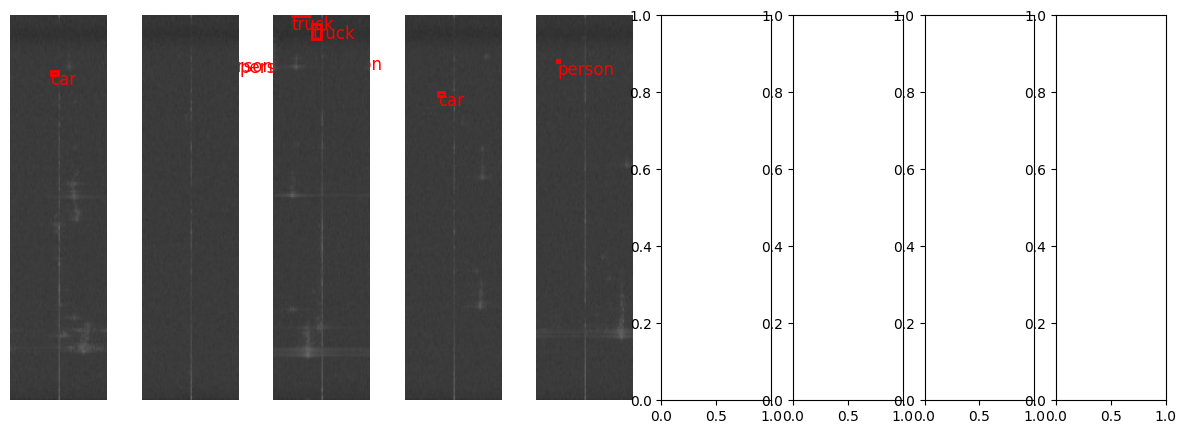

In [37]:
visualize_images_with_boxes(df)

# Train

In [17]:
cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml" 
# config_name = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))

cfg.DATASETS.TRAIN = (data_name,)
cfg.DATASETS.TEST = (val_name,)
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 3500  #adjust up if val mAP is still rising, adjust down if overfit
#cfg.SOLVER.STEPS = (100, 500) # must be less than  MAX_ITER 
#cfg.SOLVER.GAMMA = 0.05


cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


#Training using custom trainer defined above
# trainer = AugTrainer(cfg) 
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/24 20:44:41 d2.utils.events]:  eta: 0:28:33  iter: 39  total_loss: 1.826  loss_cls: 1.68  loss_box_reg: 0.0213  loss_rpn_cls: 0.06749  loss_rpn_loc: 0.004506    time: 0.4985  last_time: 0.4938  data_time: 0.0327  last_data_time: 0.0312   lr: 9.9903e-06  max_mem: 2369M
[04/24 20:44:51 d2.utils.events]:  eta: 0:28:30  iter: 59  total_loss: 1.198  loss_cls: 1.024  loss_box_reg: 0.01433  loss_rpn_cls: 0.08977  loss_rpn_loc: 0.006571    time: 0.4997  last_time: 0.5051  data_time: 0.0337  last_data_time: 0.0339   lr: 1.4985e-05  max_mem: 2369M
[04/24 20:45:01 d2.utils.events]:  eta: 0:28:27  iter: 79  total_loss: 0.6038  loss_cls: 0.4475  loss_box_reg: 0.01552  loss_rpn_cls: 0.07286  loss_rpn_loc: 0.0052    time: 0.5011  last_time: 0.5086  data_time: 0.0330  last_data_time: 0.0353   lr: 1.998e-05  max_mem: 2369M
[04/24 20:45:11 d2.utils.events]:  eta: 0:28:27  iter: 99  total_loss: 0.2704  loss_cls: 0.1797  loss_box_reg: 0.01553  loss_rpn_cls: 0.06969  loss_rpn_loc: 0.005758    time: 0.5